# Multilayer Perceptum (MLP) <a name="multilayer"></a>


We are going to use **Multilayer Perceptron (MLP)** because it is a flexible neural network architecture. MLPs are great for solving **classification problems**

For this model we will define the model architecture and the training strategy consisting in:
- **Number of layers**
- **Number of neurons of each layer**
- **Choice of the activation functions**
- **Optimizer** 
- **Learning hyperparameters** (e.g., learning rate, mini-batch size, number of epochs, etc.)
- **Regularization techniques to adopt** (e.g., early stopping, weight regularization, dropout)

The network works by processing data through **multiple layers**, with each layer learning to capture different features of the input data.

### Model architecture definition and Training Strategy <a name="archi-train"></a>

For the architecture of our MLP model we need, as mentioned above, the number of layers, neurons, and choose the activation functions such as relu, softmax and Tanh for example.

We used **dictionaries** to organize and store different options for **hyperparameters**. This allows us to easily experiment with different configurations and manage the settings efficiently.

To optimize our model, we decided to do a grid search to **update and select the best hyperparameter combination in the first iteration**. This means that in the beginning, we test several combinations of hyperparameters to find the one that performs best. By doing this, we can quickly narrow down the best model for our task, improving the **accuracy** of the predictions.

Additionally, we will use the **ADAM** optimizer, which is a popular choice for training neural networks due to its adaptive learning rate and efficient performance.
We also implemented **early stopping** to prevent overfitting by monitoring the model's performance and halting training when it stops improving.

In this way, the process of **testing and updating** in the first iteration helps us fine-tune the model efficiently, and **selecting the best combination** ensures we are using the most effective settings for our dataset.

The following table defines the possible combinations of hyperparameters we tested:

| <span style="color: #C70039;">**Hyperparameter**</span> | <span style="color: #C70039;">**Options**</span>        |
|-----------------------------------------------------|-------------------------------------------------------|
| <span style="color: #00bfae;">**Hidden Units**</span> | [128, 64, 32], [256, 128, 64], [256, 128, 64, 32]                |
| <span style="color: #00bfae;">**Activation Functions**</span> | reLU, sigmoid, tanh                             |
| <span style="color: #00bfae;">**Dropout Rate**</span> | 0.2, 0.3, 0.4                                         |
| <span style="color: #00bfae;">**Batch Size**</span>   | 32, 64                                               |
| <span style="color: #00bfae;">**Epochs**</span>       | 20, 50                                                 |
| <span style="color: #00bfae;">**Regularizations**</span>       | None, L1 (Lasso), L2 (Ridge)                                            |
| <span style="color: #00bfae;">**Learning Rate**</span> | 0.001, 0.0001                                     |


<span style="color: #C70039;">**Note:**</span>
- <span style="color: #00bfae;">**Hidden Units**</span> consists in the number of layers and the number of each neurons of each layer, for example in this case [256, 128, 64], it defines 3 layers with 256, 128 and 64 neurons, respectively.


### MLP Implementation  <a name="multilayer"></a>
[[go back to the top]](#multilayer)

Here we start the MLP implementation with the provided explanation of our workflow.

##### Imports

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import itertools
from pathos.multiprocessing import Pool
import random 
import os
import matplotlib.pyplot as plt

##### Class MLP
[[go back to the topic]](#mlp-implementation)

Defines a flexible Multi-Layer Perceptron (MLP) with configurable layers, dropout, activation functions, and optional **l1** or **l2** regularization. Includes a method to compute regularization loss for better generalization.

In [3]:
class MLP(tf.keras.Model):
    def __init__(self, input_dim, output_dim, hidden_units, dropout_rate, activations, regularization_type=None, regularization_value=0.01):
        super(MLP, self).__init__()
        self.hidden_layers = []
        self.regularization_type = regularization_type
        self.regularization_value = regularization_value

        for units, activation in zip(hidden_units, activations):
            self.hidden_layers.append(
                tf.keras.layers.Dense(units, activation=activation)
            )
            self.hidden_layers.append(tf.keras.layers.Dropout(dropout_rate))
        
        self.output_layer = tf.keras.layers.Dense(output_dim, activation='softmax')  


    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)
    
    def compute_regularization_loss(self):
        regularization_loss = 0.0
        if self.regularization_type:
            for layer in self.hidden_layers:
                if isinstance(layer, tf.keras.layers.Dense):
                    weights = layer.kernel
                    if self.regularization_type == 'l1':
                        regularization_loss += tf.reduce_sum(tf.abs(weights)) * self.regularization_value
                    elif self.regularization_type == 'l2':
                        regularization_loss += tf.reduce_sum(tf.square(weights)) * self.regularization_value
        return regularization_loss

##### Hyperparameter Configuration Generator and Load Fold Data
[[go back to the topic]](#mlp-implementation)

Generates all possible combinations of hyperparameter configurations from a dictionary of options using Cartesian product. Loads features and labels from a specific fold's dataset file, separating the Label column from the feature matrix for training and evaluation purposes.

In [7]:
def generate_configs(configurations):
    keys, values = zip(*configurations.items())
    return [dict(zip(keys, v)) for v in itertools.product(*values)]

def load_fold_data(fold_number, files):
    data = pd.read_csv(files[fold_number])
    labels = data.pop('Label').values
    features = data.values
    return features, labels

##### Train, Evaluate, and Cross-Validate MLP
[[go back to the topic]](#mlp-implementation)

This code trains and evaluates the MLP model using a specified configuration and implements single-fold cross-validation. The training process includes a custom loss function that integrates a regularization term to improve generalization, uses early stopping to prevent overfitting, and calculates validation accuracy on the held-out fold.

In [8]:
def train_evaluate_model(config, X_train, y_train, X_val, y_val):
    model = MLP(
        input_dim=X_train.shape[1],
        output_dim=10,
        hidden_units=config['hidden_units'],
        dropout_rate=config['dropout_rate'],
        activations=config['activations'],
        regularization_type=config.get('regularization_type', None),
        regularization_value=config.get('regularization_value', 0.01)
    )
    
    def loss_with_regularization(y_true, y_pred):
        base_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        regularization_loss = model.compute_regularization_loss()
        return base_loss + regularization_loss

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
        loss=loss_with_regularization,
        metrics=['accuracy']
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=config['batch_size'],
        epochs=config['epochs'],
        callbacks=[early_stopping],
        verbose=0
    )

    return history.history


# Cross-validation, just one iteration (1 fold)
def cross_validate_model(config, files):
    # Only the first fold for validation
    fold_number = 0
    X_val, y_val = load_fold_data(fold_number, files)
    X_train, y_train = [], []
    
    # Training with other folds
    for i in range(len(files)):
        if i != fold_number:
            X_temp, y_temp = load_fold_data(i, files)
            X_train.append(X_temp)
            y_train.append(y_temp)
    
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    
    # Train and evaluate for this fold
    accuracy = train_evaluate_model(config, X_train, y_train, X_val, y_val)
    return accuracy  

##### Parallel Evaluation and Activation Combination Generation
[[go back to the topic]](#mlp-implementation)

This code enables parallel evaluation of model configurations by performing cross-validation and logging the results (configuration and accuracy). It also generates random activation function combinations for different hidden layer structures, creating varied configurations for testing and optimization. The results are saved in a log file for later analysis.

In [9]:
def evaluate_config_parallel(args):
    config, files = args
    accuracy = cross_validate_model(config, files)
    
    with open("results_log.txt", "a") as f:
        f.write(f"Configuration: {config} | Accuracy: {accuracy}\n")
    
    return config, accuracy

def generate_activation_combinations(hidden_units_list, activations_list = ['relu', 'sigmoid', 'tanh'], num_combinations=1):
    activation_combinations = []
    for hidden_units in hidden_units_list:
        layers = len(hidden_units)
        for _ in range(num_combinations):
            random_combination = [random.choice(activations_list) for _ in range(layers)]
            activation_combinations.append((hidden_units, random_combination))  
    return activation_combinations

##### Generate and Select Hyperparameter Configurations
[[go back to the topic]](#mlp-implementation)

This code generates combinations of hidden units, activation functions, and other hyperparameters such as dropout rate, batch size, epochs, and regularization settings. It then creates a list of all possible configurations for model training.

In [ ]:
hidden_units_list = [[128, 64, 32], [256, 128, 64], [256, 128, 64, 32]]

activation_combinations = generate_activation_combinations(hidden_units_list)

hidden_units = [combo[0] for combo in activation_combinations]
activations = [combo[1] for combo in activation_combinations]

configurations = {
    "hidden_units": hidden_units,  
    "activations": activations,    
    "dropout_rate": [0.2, 0.3, 0.4],
    "batch_size": [32,64],
    "epochs": [20,50],
    "learning_rate": [0.001, 0.0001],
    "regularization_type": [None, 'l1', 'l2'],
    "regularization_value": [0.01, 0.001],
}

files = [f'datasets/urbansounds_features_fold{i}.csv' for i in range(1,11)] 

all_configs = generate_configs(configurations)

### Parallel Evaluation and Best Configuration Selection
[[go back to the topic]](#mlp-implementation)

This code evaluates different model configurations in parallel using multiple workers. It first removes any existing result files (**results_log.txt**) to ensure a clean start. Then, it uses a multiprocessing pool with 8 workers to evaluate each configuration in **all_configs**. The results are logged and the best configuration, based on accuracy, is selected and printed.

In [ ]:
if os.path.exists("results_log.txt"):
    os.remove("results_log.txt")
num_workers = 8
with Pool(num_workers) as pool:
    results = pool.map(evaluate_config_parallel, [(config, files) for config in all_configs])

# Find the best configuration
best_config, best_accuracy = max(results, key=lambda x: x[1])
print(f"Best configuration: {best_config}, Best accuracy: {best_accuracy}")

Best configuration: {'hidden_units': [256, 128, 64], 'activations': ['relu', 'relu', 'relu'], 'dropout_rate': 0.3, 'batch_size': 64, 'epochs': 20, 'learning_rate': 0.0001, 'regularization_type': None, 'regularization_value': 0.01}, Best accuracy: 0.7216494679450989


Based on the optimal hyperparameter configuration identified: **'hidden_units':** [256, 128, 64], **'activations':** ['relu', 'relu', 'relu'], **'dropout_rate':** 0.3, **'batch_size':** 64, **'epochs':** 20, **'learning_rate':** 0.0001, **'regularization_type':** None, **'regularization_value':** 0.01** with a **best accuracy** of 0.7216, we will now implement data augmentation techniques to evaluate and enhance model robustness.

### Data Augmentation
[[go back to the topic]](#multilayer)


We are applying data augmentation to enhance the diversity of our dataset. Techniques include **adding noise**, **scaling feature values**, **simulating 
pitch shifts**, and **equalizing frequency ranges**.

These transformations aim to improve model **generalization** and **robustness**.

In [43]:
def add_noise(features, noise_level=0.01):
    noise = np.random.normal(0, noise_level, features.shape)
    return features + noise

def scale_features(features, scale_range=(0.9, 1.1)):
    scale_factor = np.random.uniform(scale_range[0], scale_range[1], features.shape)
    return features * scale_factor

def pitch_shift(features, shift_range=(-2, 2)):
    """
    Aplica uma modificação simulada nos MFCCs para simular pitch shifting.
    shift_range define o número de semitons.
    """
    shift_value = np.random.uniform(*shift_range)  
    shifted_features = features.copy()
    if shifted_features.shape[1] >= 13:  
        shifted_features[:, :13] += shift_value
    return shifted_features

def equalize(features, eq_factor=1.5):
    """
    Simula equalização amplificando as frequências médias.
    Amplificação arbitrária nas colunas centrais.
    """
    features = np.copy(features)
    mid_point = features.shape[1] // 2
    if mid_point - 5 >= 0 and mid_point + 5 < features.shape[1]:
        features[:, mid_point - 5:mid_point + 5] *= eq_factor
    return features

def augment_data(features, labels, augmentation_count=2):
    augmented_features = []
    augmented_labels = []
    for _ in range(augmentation_count):
        augmented_features.append(add_noise(features))
        augmented_features.append(scale_features(features))
        augmented_features.append(pitch_shift(features))
        augmented_features.append(equalize(features))
        augmented_labels.extend(labels)
        augmented_labels.extend(labels)
        augmented_labels.extend(labels)
        augmented_labels.extend(labels)
    return np.vstack(augmented_features), np.array(augmented_labels)


Now we are going to apply data augmentation to audio feature datasets. For each file, we augment the features.

In [ ]:
def augment_csv_files(files, output_dir="augmented_datasets"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for file in files:
        data = pd.read_csv(file)
        labels = data.pop('Label').values
        features = data.values
        
        # Perform data augmentation
        aug_features, aug_labels = augment_data(features, labels, augmentation_count=2)
        
        # Combine original data with augmented data
        combined_features = np.vstack((features, aug_features))
        combined_labels = np.hstack((labels, aug_labels))
        
        # Save the new CSV
        combined_data = pd.DataFrame(combined_features, columns=data.columns)
        combined_data['Label'] = combined_labels
        output_file = os.path.join(output_dir, os.path.basename(file))
        combined_data.to_csv(output_file, index=False)
        print(f"Augmented data saved to {output_file}")

files = [f'datasets/urbansounds_features_fold{i}.csv' for i in range(1, 11)]
augment_csv_files(files)


Augmented data saved to augmented_datasets/urbansounds_features_fold1.csv
Augmented data saved to augmented_datasets/urbansounds_features_fold2.csv
Augmented data saved to augmented_datasets/urbansounds_features_fold3.csv
Augmented data saved to augmented_datasets/urbansounds_features_fold4.csv
Augmented data saved to augmented_datasets/urbansounds_features_fold5.csv
Augmented data saved to augmented_datasets/urbansounds_features_fold6.csv
Augmented data saved to augmented_datasets/urbansounds_features_fold7.csv
Augmented data saved to augmented_datasets/urbansounds_features_fold8.csv
Augmented data saved to augmented_datasets/urbansounds_features_fold9.csv
Augmented data saved to augmented_datasets/urbansounds_features_fold10.csv


### 10-fold cross-validation on the augmented datasets


**Cross-Validation Schema**:
   - **1 Fold** for **Testing**: Original data only.
   - **1 Fold** for **Validation**: Original data only.
   - **8 Folds** for **Training**: Augmented data.



. Train the model using the augmented training set and the best configuration (`best_config`).

. Evaluate the model on the test set after training.


In [6]:
# Best configuration já definida
best_config = {
    'hidden_units': [256, 128, 64],
    'activations': ['relu', 'relu', 'relu'],
    'dropout_rate': 0.3,
    'batch_size': 64,
    'epochs': 20,
    'learning_rate': 0.0001,
    'regularization_type': None,
    'regularization_value': 0.01
}

def load_augmented_data(fold_number, augmented_files):
    return load_fold_data(fold_number, augmented_files)

def load_fold_data(fold_number, files):
    data = pd.read_csv(files[fold_number - 1]) 
    if data.empty:
        print(f"Erro: O arquivo {files[fold_number - 1]} está vazio ou não foi carregado corretamente.")
    labels = data.pop('Label').values
    features = data.values
    return features, labels


def train_evaluate_model(config, X_train, y_train, X_val, y_val):
    model = MLP(
        input_dim=X_train.shape[1],
        output_dim=10,
        hidden_units=config['hidden_units'],
        dropout_rate=config['dropout_rate'],
        activations=config['activations'],
        regularization_type=config.get('regularization_type', None),
        regularization_value=config.get('regularization_value', 0.01)
    )
    
    def loss_with_regularization(y_true, y_pred):
        base_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        regularization_loss = model.compute_regularization_loss()
        return base_loss + regularization_loss

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
        loss=loss_with_regularization,
        metrics=['accuracy']
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=config['batch_size'],
        epochs=config['epochs'],
        callbacks=[early_stopping],
        verbose=0
    )

    print("one")
    return history  




In [14]:

def train_evaluate_model(config, X_train, y_train, X_val, y_val):
    model = MLP(
        input_dim=X_train.shape[1],
        output_dim=10,
        hidden_units=config['hidden_units'],
        dropout_rate=config['dropout_rate'],
        activations=config['activations'],
        regularization_type=config.get('regularization_type', None),
        regularization_value=config.get('regularization_value', 0.01)
    )
    
    def loss_with_regularization(y_true, y_pred):
        base_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        regularization_loss = model.compute_regularization_loss()
        return base_loss + regularization_loss

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
        loss=loss_with_regularization,
        metrics=['accuracy']
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=config['batch_size'],
        epochs=config['epochs'],
        callbacks=[early_stopping],
        verbose=0
    )

    print("one")
    return history  

def evaluate_on_test(config, X_train, y_train, X_test, y_test):
    model = MLP(
        input_dim=X_train.shape[1],
        output_dim=10,
        hidden_units=config['hidden_units'],
        dropout_rate=config['dropout_rate'],
        activations=config['activations'],
        regularization_type=config.get('regularization_type', None),
        regularization_value=config.get('regularization_value', 0.01)
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    model.fit(X_train, y_train, batch_size=config['batch_size'], epochs=config['epochs'], verbose=0)
    
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    return test_loss, test_accuracy


def cross_validate_with_test_and_plot(files, augmented_files, best_config):
    import matplotlib.pyplot as plt
    import numpy as np

    folds = list(range(1, 11))
    all_histories = []

    for test_fold in folds:
        print(f"Analyzing Test Fold {test_fold}")

        train_val_folds = [fold for fold in folds if fold != test_fold]

        for val_fold in train_val_folds:
            print(f"Test Fold: {test_fold}, Validation Fold: {val_fold}")

            # Training folds
            train_folds = [fold for fold in train_val_folds if fold != val_fold]

            # Load training data
            X_train, y_train = [], []
            for fold in train_folds:
                X_temp, y_temp = load_augmented_data(fold, augmented_files)
                X_train.append(X_temp)
                y_train.append(y_temp)
            X_train = np.concatenate(X_train, axis=0)
            y_train = np.concatenate(y_train, axis=0)

            # Load validation and test data
            X_val, y_val = load_augmented_data(val_fold, augmented_files)
            X_test, y_test = load_fold_data(test_fold, files)

            # Train and evaluate on validation fold
            history = train_evaluate_model(best_config, X_train, y_train, X_val, y_val)
            all_histories.append((test_fold, val_fold, history))  # Guardar histórico para análise futura

        # Plot individual fold history after all validation folds
        plot_test_fold_summary(test_fold, history)

    return all_histories






def compute_average_histories(histories):
    import numpy as np

    # Descobrir o menor número de épocas entre todos os folds
    min_epochs = min(len(h.history['accuracy']) for h in histories if 'accuracy' in h.history)

    # Padronizar os históricos para que todos tenham o mesmo comprimento
    def truncate_or_pad(histories, key):
        return np.array([h.history[key][:min_epochs] for h in histories if key in h.history])

    averaged_history = {
        'accuracy': np.mean(truncate_or_pad(histories, 'accuracy'), axis=0),
        'val_accuracy': np.mean(truncate_or_pad(histories, 'val_accuracy'), axis=0),
        'loss': np.mean(truncate_or_pad(histories, 'loss'), axis=0),
        'val_loss': np.mean(truncate_or_pad(histories, 'val_loss'), axis=0),
    }
    return averaged_history



def print_statistics(mean_accuracy, std_accuracy):
    print(f"Final Mean Accuracy: {mean_accuracy}, Final Std Dev: {std_accuracy}")

def plot_test_fold_summary(test_fold, history):
    import matplotlib.pyplot as plt

    epochs = range(1, len(history.history['accuracy']) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    # Gráfico de acurácia
    axs[0].plot(epochs, history.history['accuracy'], label='Train Accuracy', color='blue')
    axs[0].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    axs[0].set_title(f'Test Fold {test_fold} - Accuracy over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')
    axs[0].grid(alpha=0.3)

    # Gráfico de perda
    axs[1].plot(epochs, history.history['loss'], label='Train Loss', color='green')
    axs[1].plot(epochs, history.history['val_loss'], label='Validation Loss', color='red')
    axs[1].set_title(f'Test Fold {test_fold} - Loss over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='upper right')
    axs[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:

#está a funcionar, basta rodar e passado 50 mi está feito :)

files = [f'datasets/urbansounds_features_fold{i}.csv' for i in range(1, 11)]
augmented_files=[f'augmented_datasets/urbansounds_features_fold{i}.csv' for i in range(1, 11)]
# Executando a validação cruzada
cross_validate_with_test_and_plot(files, augmented_files, best_config)



Analisando Test Fold 1
Test Fold: 1, Validation Fold: 2


KeyboardInterrupt: 

### 10-fold cross-validation on the original datasets

The schema is the same as the previous one but this time we only use the original data: 

   - **1 Fold** for **Testing**: Original data.
   - **1 Fold** for **Validation**: Original data.
   - **8 Folds** for **Training**: Original data.

Analyzing Test Fold 1
Test Fold: 1, Validation Fold: 2
one
Test Fold: 1, Validation Fold: 3
one
Test Fold: 1, Validation Fold: 4
one
Test Fold: 1, Validation Fold: 5
one
Test Fold: 1, Validation Fold: 6
one
Test Fold: 1, Validation Fold: 7
one
Test Fold: 1, Validation Fold: 8
one
Test Fold: 1, Validation Fold: 9
one
Test Fold: 1, Validation Fold: 10
one


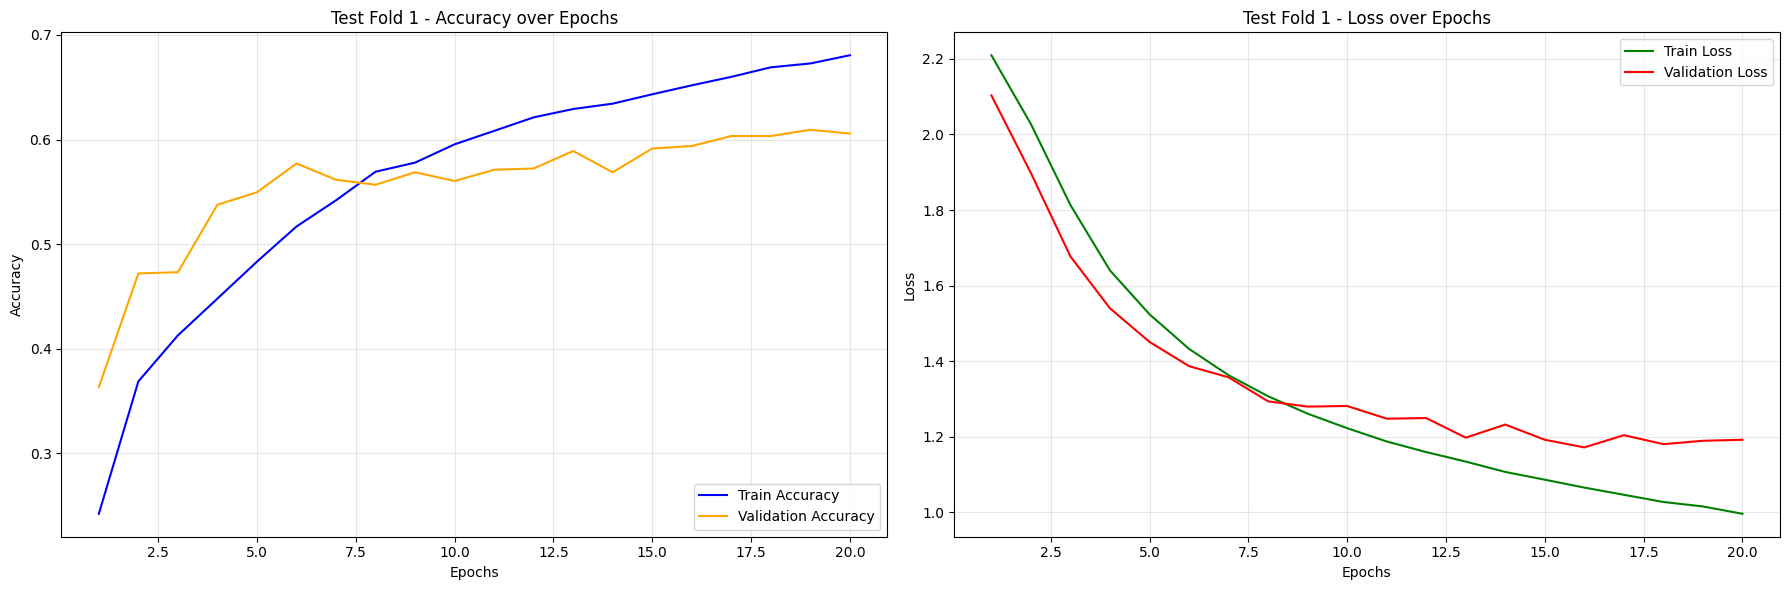

Analyzing Test Fold 2
Test Fold: 2, Validation Fold: 1
one
Test Fold: 2, Validation Fold: 3
one
Test Fold: 2, Validation Fold: 4
one
Test Fold: 2, Validation Fold: 5
one
Test Fold: 2, Validation Fold: 6
one
Test Fold: 2, Validation Fold: 7
one
Test Fold: 2, Validation Fold: 8
one
Test Fold: 2, Validation Fold: 9
one
Test Fold: 2, Validation Fold: 10
one


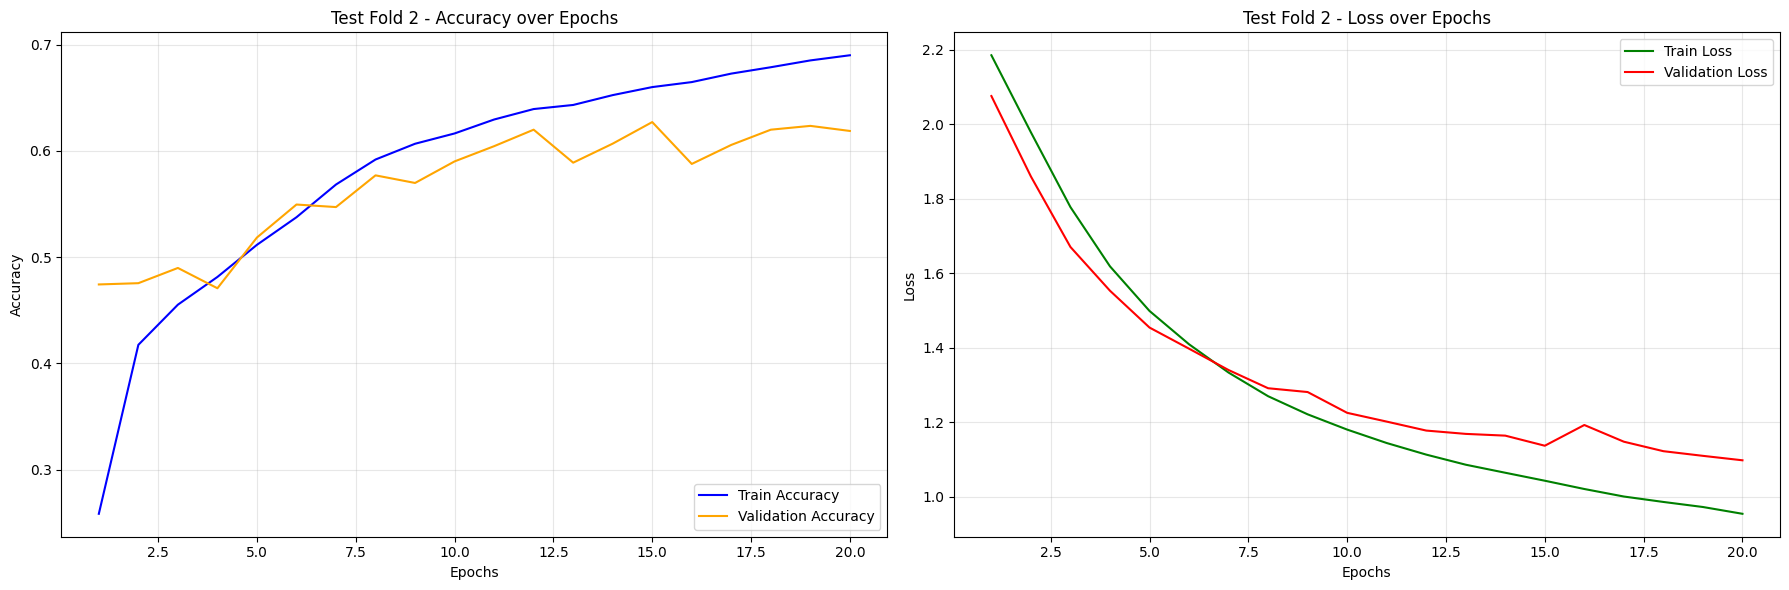

Analyzing Test Fold 3
Test Fold: 3, Validation Fold: 1
one
Test Fold: 3, Validation Fold: 2
one
Test Fold: 3, Validation Fold: 4
one
Test Fold: 3, Validation Fold: 5
one
Test Fold: 3, Validation Fold: 6
one
Test Fold: 3, Validation Fold: 7
one
Test Fold: 3, Validation Fold: 8
one
Test Fold: 3, Validation Fold: 9
one
Test Fold: 3, Validation Fold: 10
one


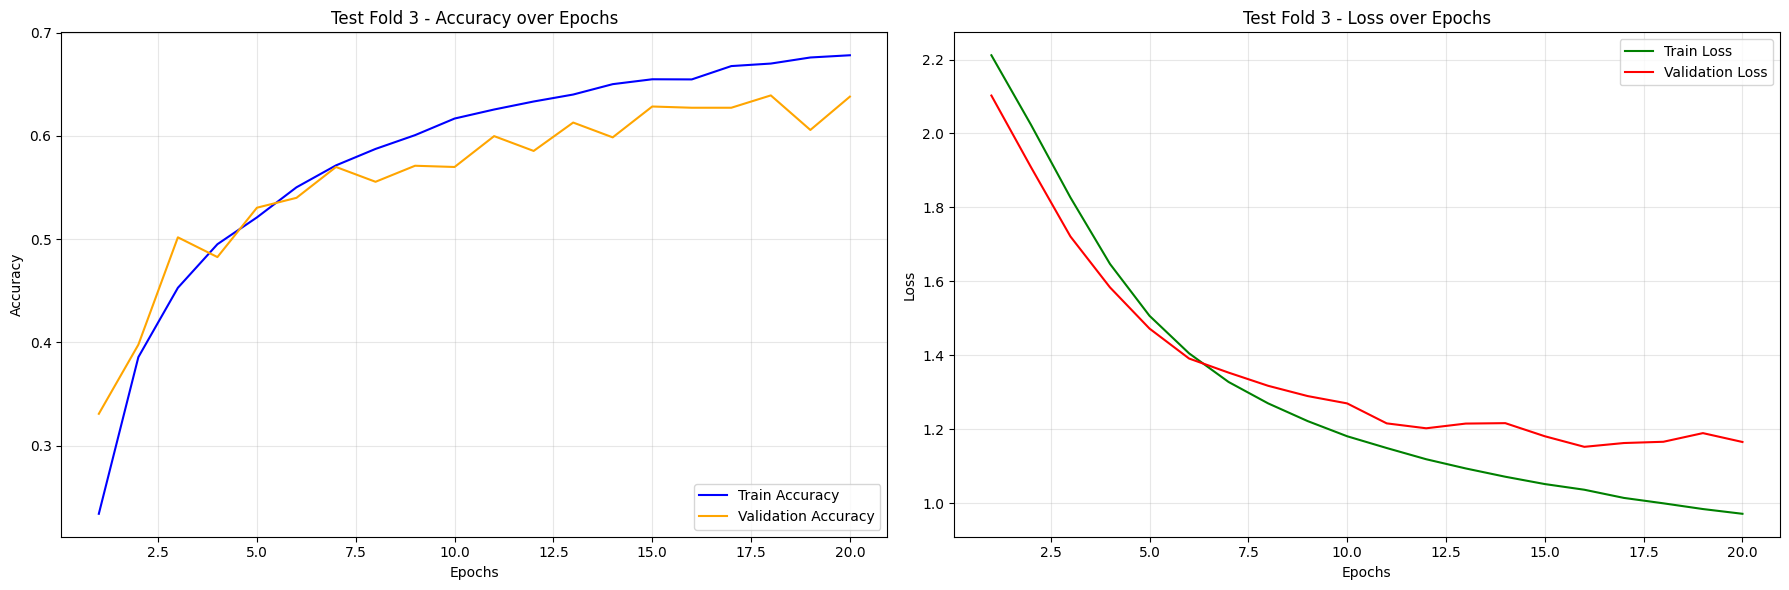

Analyzing Test Fold 4
Test Fold: 4, Validation Fold: 1
one
Test Fold: 4, Validation Fold: 2
one
Test Fold: 4, Validation Fold: 3
one
Test Fold: 4, Validation Fold: 5
one
Test Fold: 4, Validation Fold: 6
one
Test Fold: 4, Validation Fold: 7
one
Test Fold: 4, Validation Fold: 8
one
Test Fold: 4, Validation Fold: 9
one
Test Fold: 4, Validation Fold: 10
one


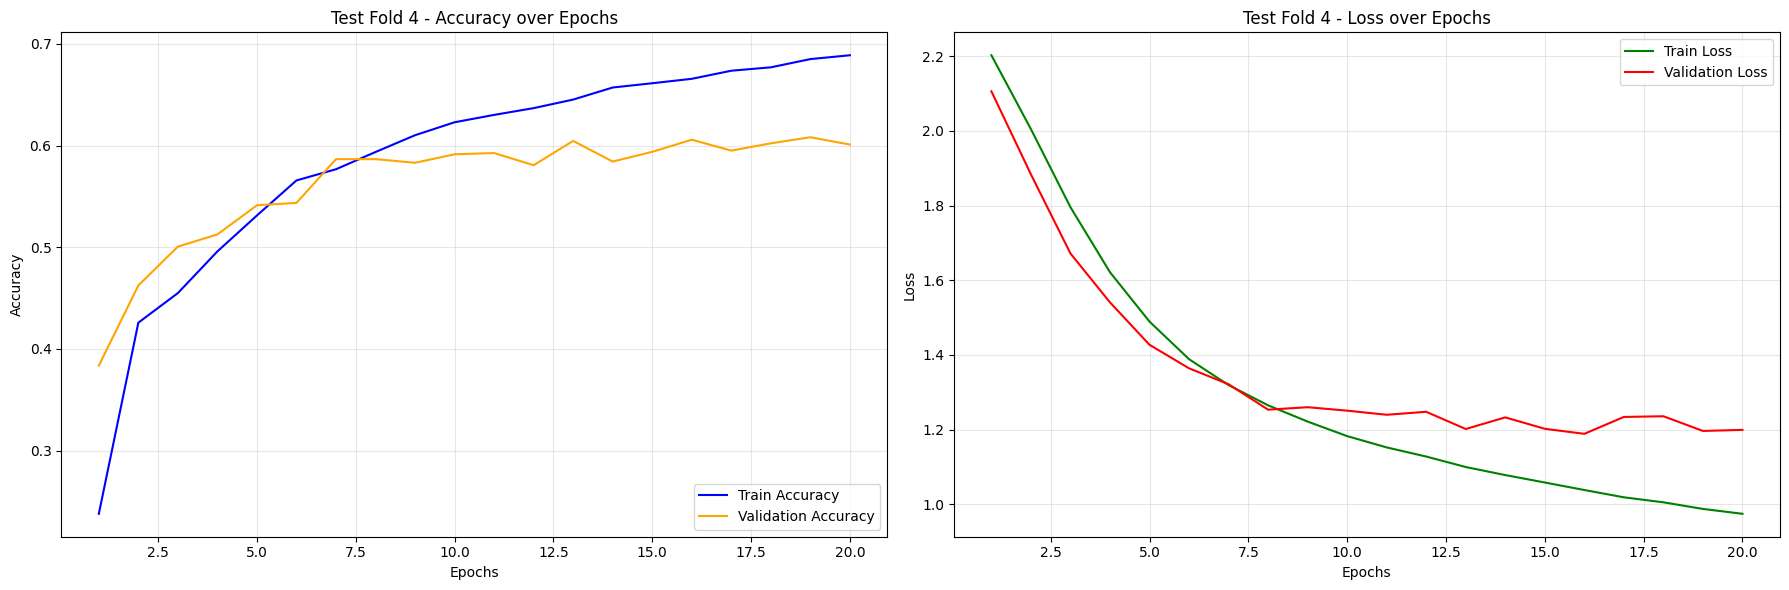

Analyzing Test Fold 5
Test Fold: 5, Validation Fold: 1
one
Test Fold: 5, Validation Fold: 2
one
Test Fold: 5, Validation Fold: 3
one
Test Fold: 5, Validation Fold: 4
one
Test Fold: 5, Validation Fold: 6
one
Test Fold: 5, Validation Fold: 7
one
Test Fold: 5, Validation Fold: 8
one
Test Fold: 5, Validation Fold: 9
one
Test Fold: 5, Validation Fold: 10
one


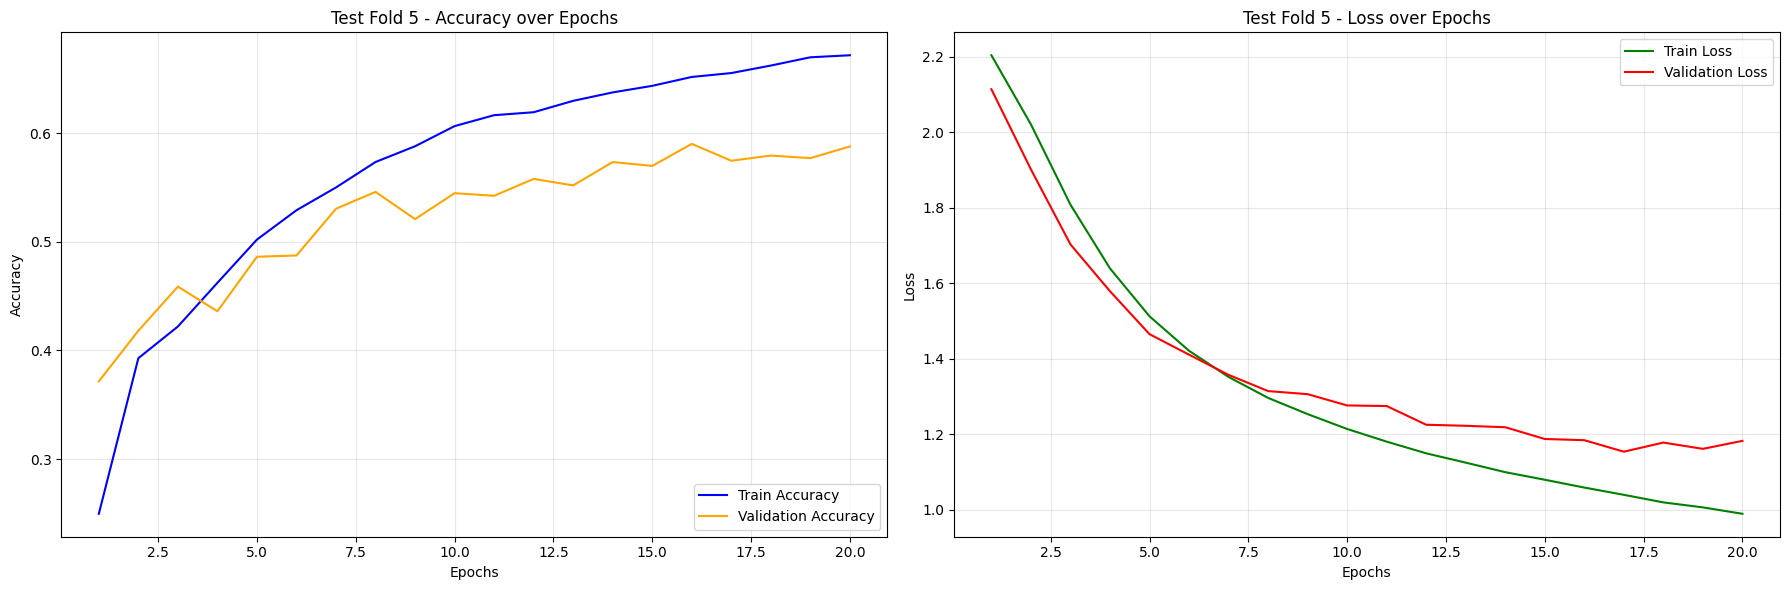

Analyzing Test Fold 6
Test Fold: 6, Validation Fold: 1
one
Test Fold: 6, Validation Fold: 2
one
Test Fold: 6, Validation Fold: 3
one
Test Fold: 6, Validation Fold: 4
one
Test Fold: 6, Validation Fold: 5
one
Test Fold: 6, Validation Fold: 7
one
Test Fold: 6, Validation Fold: 8
one
Test Fold: 6, Validation Fold: 9
one
Test Fold: 6, Validation Fold: 10
one


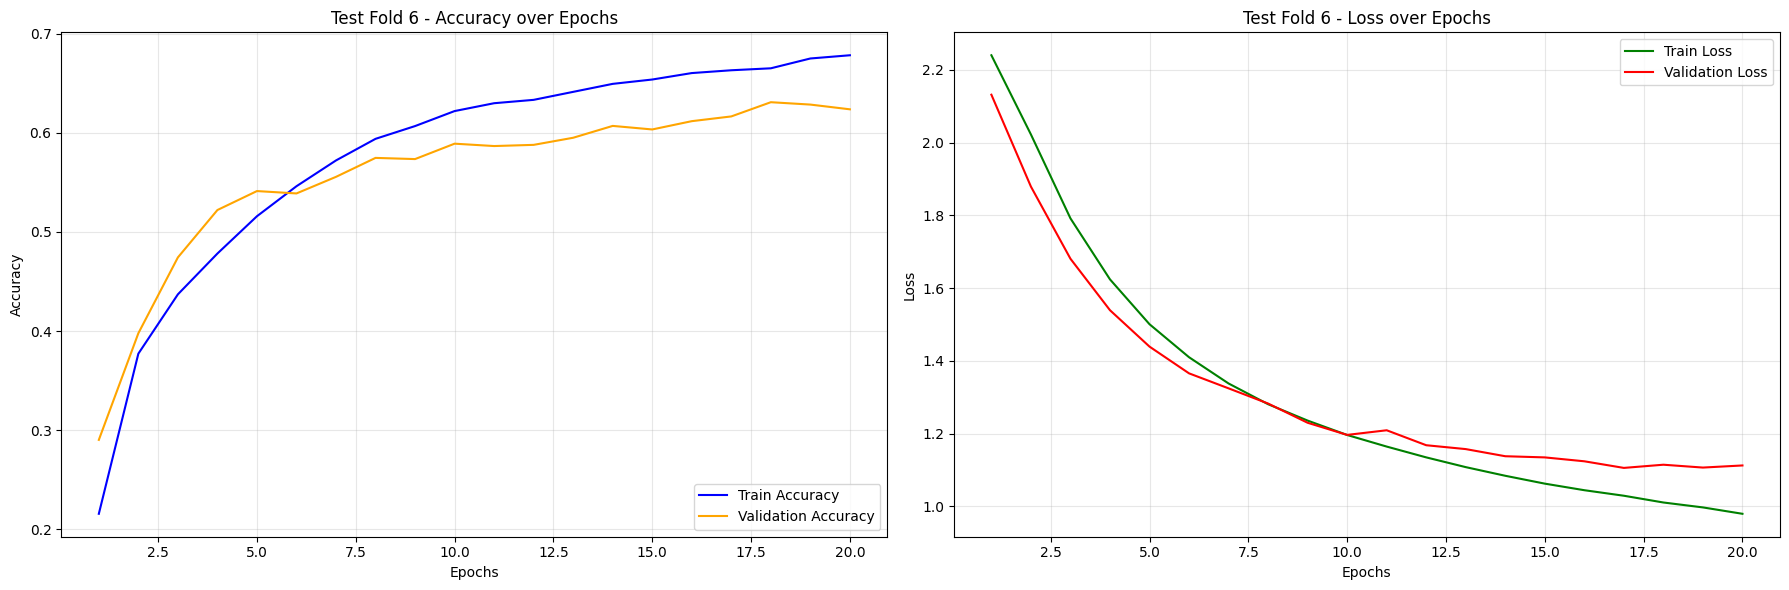

Analyzing Test Fold 7
Test Fold: 7, Validation Fold: 1
one
Test Fold: 7, Validation Fold: 2
one
Test Fold: 7, Validation Fold: 3
one
Test Fold: 7, Validation Fold: 4
one
Test Fold: 7, Validation Fold: 5
one
Test Fold: 7, Validation Fold: 6
one
Test Fold: 7, Validation Fold: 8
one
Test Fold: 7, Validation Fold: 9
one
Test Fold: 7, Validation Fold: 10
one


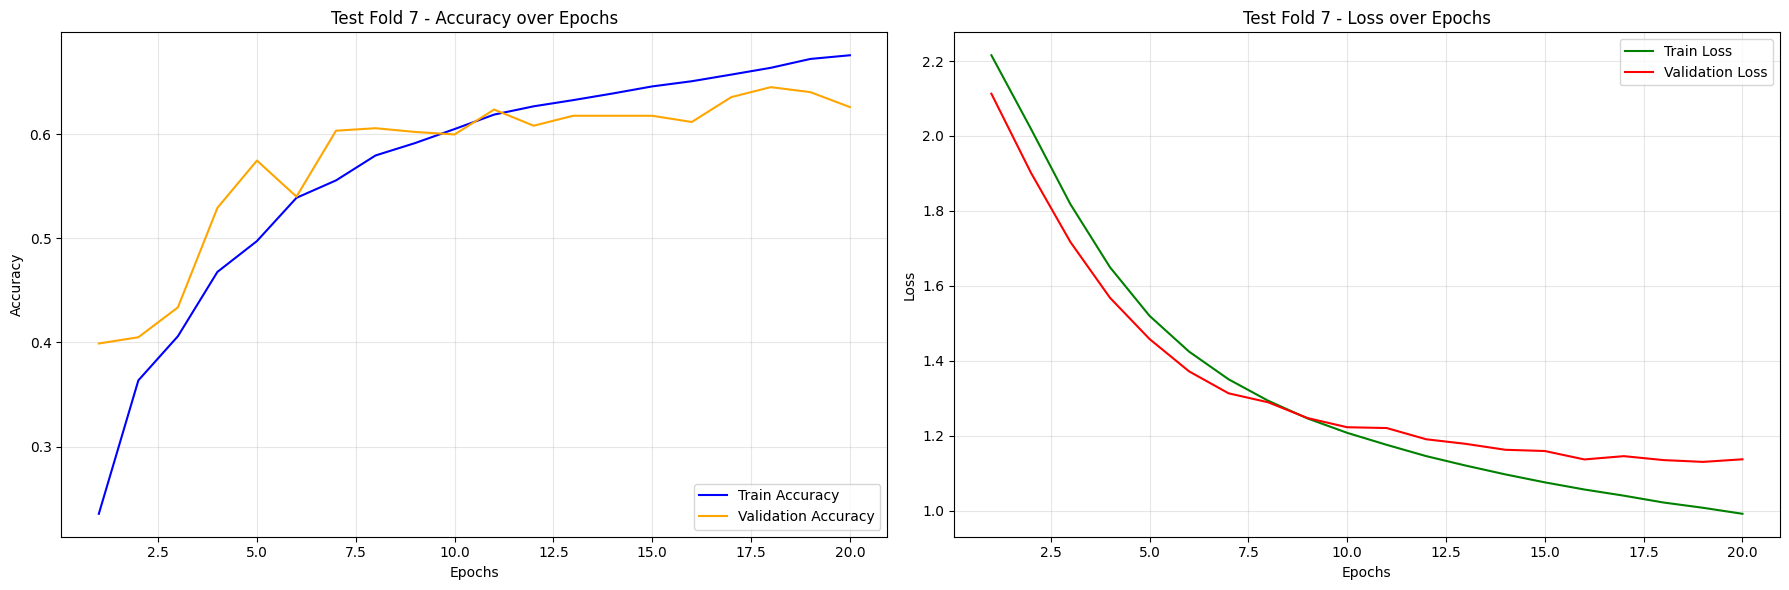

Analyzing Test Fold 8
Test Fold: 8, Validation Fold: 1
one
Test Fold: 8, Validation Fold: 2
one
Test Fold: 8, Validation Fold: 3
one
Test Fold: 8, Validation Fold: 4
one
Test Fold: 8, Validation Fold: 5
one
Test Fold: 8, Validation Fold: 6
one
Test Fold: 8, Validation Fold: 7
one
Test Fold: 8, Validation Fold: 9
one
Test Fold: 8, Validation Fold: 10
one


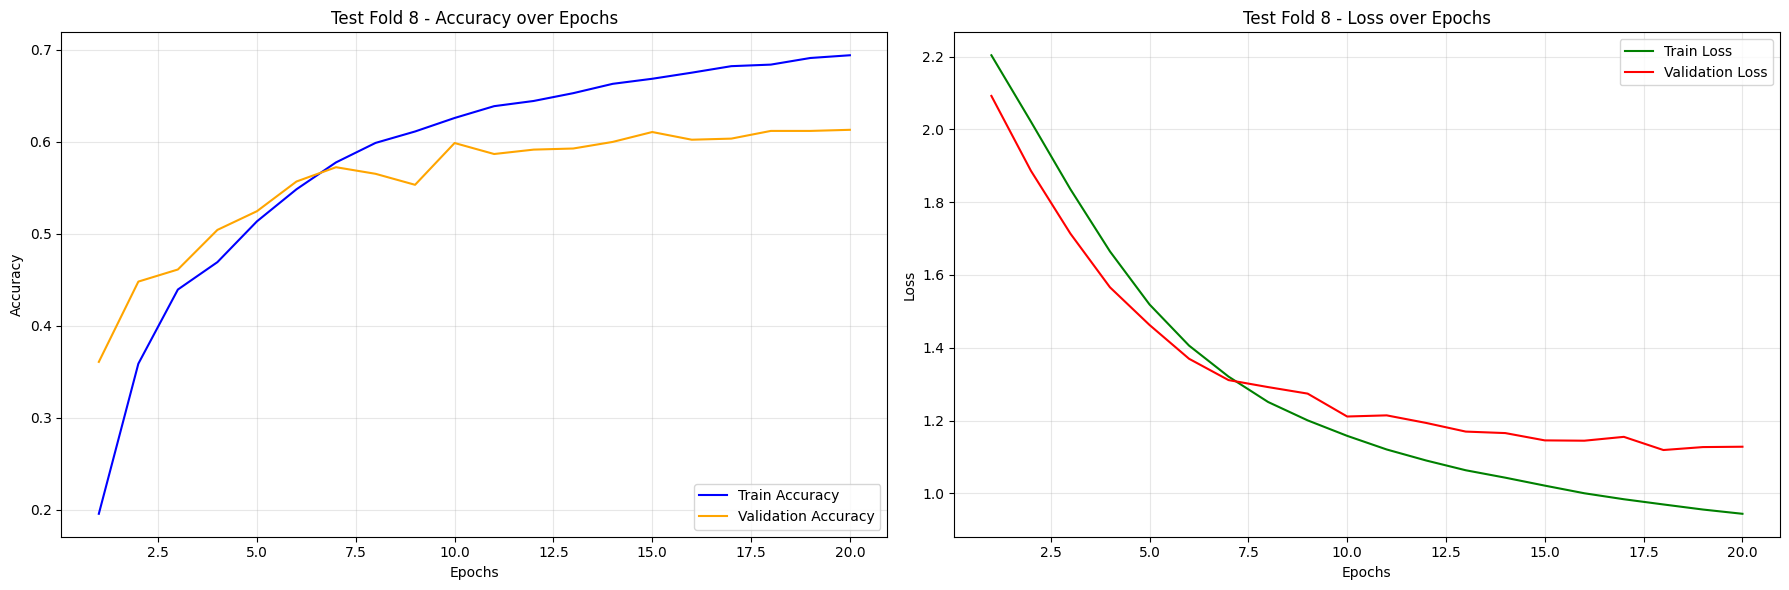

Analyzing Test Fold 9
Test Fold: 9, Validation Fold: 1
one
Test Fold: 9, Validation Fold: 2
one
Test Fold: 9, Validation Fold: 3
one
Test Fold: 9, Validation Fold: 4
one
Test Fold: 9, Validation Fold: 5
one
Test Fold: 9, Validation Fold: 6
one
Test Fold: 9, Validation Fold: 7
one
Test Fold: 9, Validation Fold: 8
one
Test Fold: 9, Validation Fold: 10
one


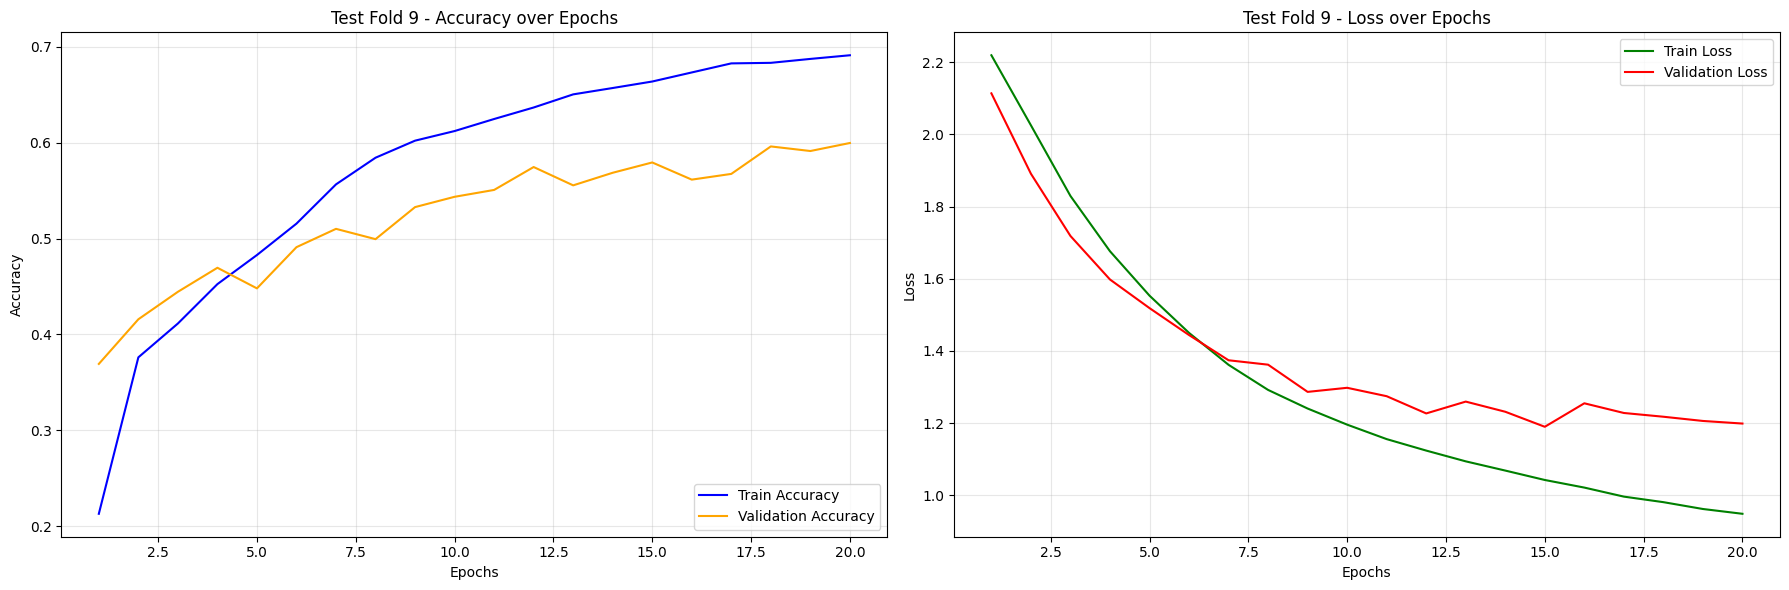

Analyzing Test Fold 10
Test Fold: 10, Validation Fold: 1
one
Test Fold: 10, Validation Fold: 2
one
Test Fold: 10, Validation Fold: 3
one
Test Fold: 10, Validation Fold: 4
one
Test Fold: 10, Validation Fold: 5
one
Test Fold: 10, Validation Fold: 6
one
Test Fold: 10, Validation Fold: 7
one
Test Fold: 10, Validation Fold: 8
one
Test Fold: 10, Validation Fold: 9
one


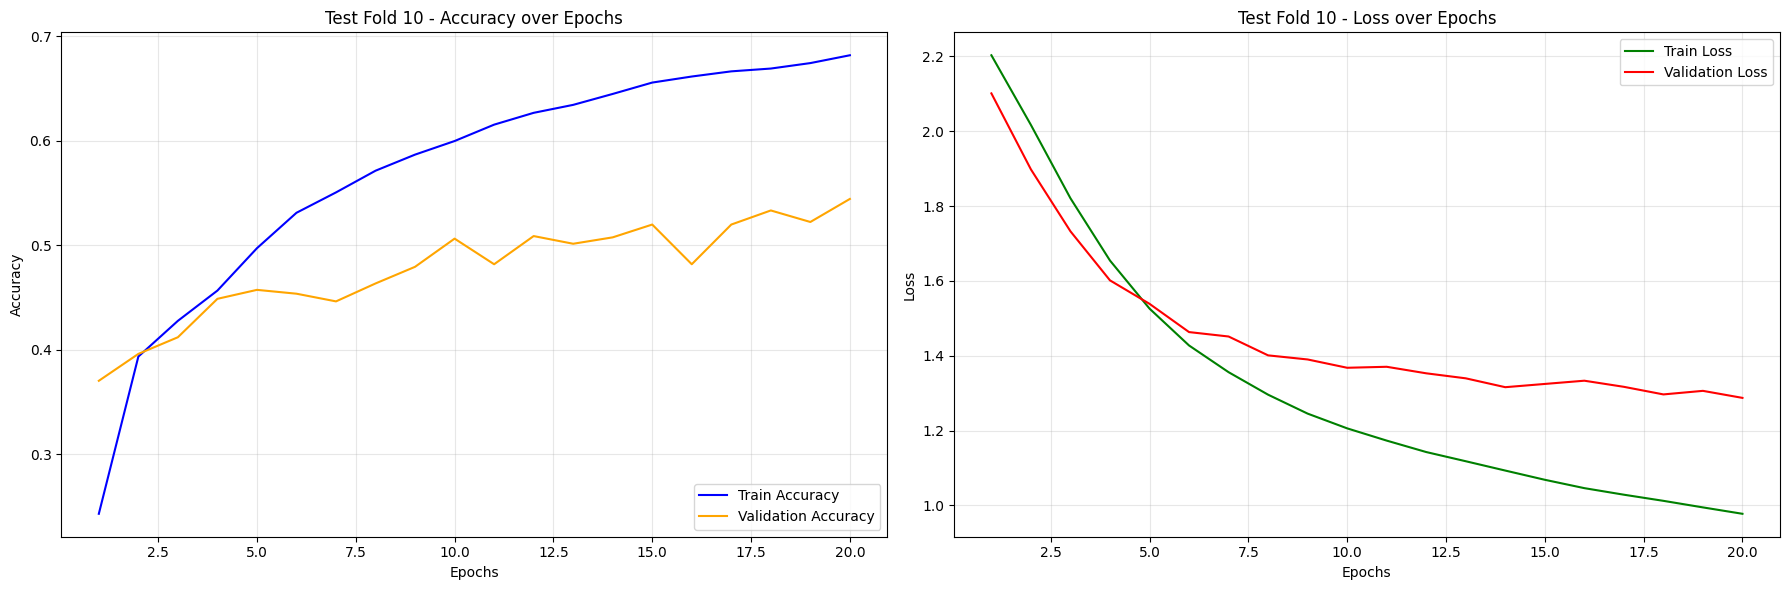

[(1, 2, <keras.src.callbacks.history.History at 0x217caf83050>),
 (1, 3, <keras.src.callbacks.history.History at 0x217c9d6e1b0>),
 (1, 4, <keras.src.callbacks.history.History at 0x217cb47cf20>),
 (1, 5, <keras.src.callbacks.history.History at 0x217ce824ce0>),
 (1, 6, <keras.src.callbacks.history.History at 0x217cfa0edb0>),
 (1, 7, <keras.src.callbacks.history.History at 0x217d0ce6180>),
 (1, 8, <keras.src.callbacks.history.History at 0x217d1e8f410>),
 (1, 9, <keras.src.callbacks.history.History at 0x217d0ce5fa0>),
 (1, 10, <keras.src.callbacks.history.History at 0x217cfaa20f0>),
 (2, 1, <keras.src.callbacks.history.History at 0x217d66b94c0>),
 (2, 3, <keras.src.callbacks.history.History at 0x217d6687500>),
 (2, 4, <keras.src.callbacks.history.History at 0x217d68da360>),
 (2, 5, <keras.src.callbacks.history.History at 0x217d91e0e60>),
 (2, 6, <keras.src.callbacks.history.History at 0x217da3b0980>),
 (2, 7, <keras.src.callbacks.history.History at 0x217da637f20>),
 (2, 8, <keras.src.callb

In [15]:
# Função principal para rodar a validação cruzada e plotar os gráficos para cada fold de teste
files = [f'datasets/urbansounds_features_fold{i}.csv' for i in range(1, 11)]

cross_validate_with_test_and_plot(files, files, best_config)